# GameTheory-8-BackwardInduction

## Induction Arriere : Resoudre les Jeux Sequentiels

Ce notebook presente l'**induction arriere** (backward induction), la methode fondamentale pour resoudre les jeux a information parfaite.

### Objectifs

1. Maitriser l'algorithme d'induction arriere
2. Comprendre le **jeu du mille-pattes** (centipede) et ses paradoxes
3. Analyser les jeux d'**escalade** (war of attrition)
4. Etudier le **paradoxe de la chaine de magasins** (Selten)
5. Explorer les limites de la rationalite parfaite

### Prerequis

- Notebook 7 : Jeux sous forme extensive

In [1]:
# Configuration et imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Any
from collections import defaultdict
import networkx as nx

# Style matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Classes de base (reprises du notebook 7)

@dataclass
class GameNode:
    """Noeud dans un arbre de jeu."""
    node_id: str
    player: int  # -1 pour terminal, 0 pour nature
    actions: List[str] = field(default_factory=list)
    children: Dict[str, 'GameNode'] = field(default_factory=dict)
    payoffs: Optional[Tuple[float, ...]] = None
    infoset: Optional[str] = None
    chance_probs: Optional[Dict[str, float]] = None
    
    def is_terminal(self) -> bool:
        return self.player == -1
    
    def is_chance(self) -> bool:
        return self.player == 0


class ExtensiveFormGame:
    """Jeu sous forme extensive."""
    
    def __init__(self, name: str, num_players: int):
        self.name = name
        self.num_players = num_players
        self.root: Optional[GameNode] = None
        self.nodes: Dict[str, GameNode] = {}
        self.infosets: Dict[str, List[str]] = defaultdict(list)
    
    def add_node(self, node: GameNode):
        self.nodes[node.node_id] = node
        if node.infoset:
            self.infosets[node.infoset].append(node.node_id)
    
    def set_root(self, node: GameNode):
        self.root = node
        self.add_node(node)

## 1. L'Algorithme d'Induction Arriere

### 1.1 Principe

Pour les jeux a **information parfaite** et **finis**, l'induction arriere est une methode de resolution optimale :

1. **Partir des feuilles** : identifier les noeuds de decision juste avant les terminaux
2. **Remonter** : a chaque noeud, le joueur choisit l'action qui maximise son gain (sachant ce qui se passera ensuite)
3. **Repeter** jusqu'a la racine

### 1.2 Proprietes

- Trouve un **equilibre de Nash parfait en sous-jeux** (SPE)
- Unique dans les jeux generiques (sans indifferences)
- Complexite lineaire en le nombre de noeuds

In [3]:
def backward_induction(game: ExtensiveFormGame) -> Dict[str, Tuple[str, Tuple[float, ...]]]:
    """
    Resout un jeu a information parfaite par induction arriere.
    
    Returns:
        Dict {node_id: (optimal_action, equilibrium_payoffs)}
    """
    solution = {}
    
    def solve(node: GameNode) -> Tuple[float, ...]:
        """Retourne les gains a l'equilibre depuis ce noeud."""
        if node.is_terminal():
            return node.payoffs
        
        if node.is_chance():
            # Esperance sur les resultats de nature
            expected = np.zeros(game.num_players)
            for action, prob in node.chance_probs.items():
                child_payoffs = solve(node.children[action])
                expected += prob * np.array(child_payoffs)
            return tuple(expected)
        
        # Noeud de decision : le joueur maximise son gain
        player = node.player
        best_action = None
        best_payoffs = None
        best_value = float('-inf')
        
        for action in node.actions:
            child_payoffs = solve(node.children[action])
            player_value = child_payoffs[player - 1]  # Indices 0-based
            
            if player_value > best_value:
                best_value = player_value
                best_action = action
                best_payoffs = child_payoffs
        
        solution[node.node_id] = (best_action, best_payoffs)
        return best_payoffs
    
    equilibrium_payoffs = solve(game.root)
    return solution, equilibrium_payoffs


def display_backward_induction(game: ExtensiveFormGame, solution: Dict):
    """Affiche la solution d'induction arriere."""
    print(f"\nSolution par induction arriere : {game.name}")
    print("="*60)
    
    for node_id, (action, payoffs) in solution.items():
        node = game.nodes[node_id]
        print(f"  Noeud {node_id} (J{node.player}): joue '{action}' -> {payoffs}")

In [4]:
# Exemple : Jeu d'entree sur le marche

def create_entry_game() -> ExtensiveFormGame:
    """Jeu d'entree avec Entrant et Incumbant."""
    game = ExtensiveFormGame("Entry Game", num_players=2)
    
    out_terminal = GameNode("out", -1, payoffs=(0, 2))
    fight_terminal = GameNode("fight", -1, payoffs=(-1, -1))
    accommodate_terminal = GameNode("accommodate", -1, payoffs=(1, 1))
    
    incumbent_node = GameNode("incumbent", 2, ["Fight", "Accommodate"], infoset="I2")
    incumbent_node.children = {"Fight": fight_terminal, "Accommodate": accommodate_terminal}
    
    entrant_node = GameNode("entrant", 1, ["Enter", "Out"], infoset="I1")
    entrant_node.children = {"Enter": incumbent_node, "Out": out_terminal}
    
    game.set_root(entrant_node)
    for node in [incumbent_node, out_terminal, fight_terminal, accommodate_terminal]:
        game.add_node(node)
    
    return game

entry_game = create_entry_game()
solution, eq_payoffs = backward_induction(entry_game)

display_backward_induction(entry_game, solution)
print(f"\nGains a l'equilibre: {eq_payoffs}")
print("\nInterpretation:")
print("  - Si l'Entrant entre, l'Incumbant prefere Accommoder (-1 < 1)")
print("  - Sachant cela, l'Entrant prefere Entrer (1 > 0)")
print("  -> La menace de 'Fight' n'est pas credible!")


Solution par induction arriere : Entry Game
  Noeud incumbent (J2): joue 'Accommodate' -> (1, 1)
  Noeud entrant (J1): joue 'Enter' -> (1, 1)

Gains a l'equilibre: (1, 1)

Interpretation:
  - Si l'Entrant entre, l'Incumbant prefere Accommoder (-1 < 1)
  - Sachant cela, l'Entrant prefere Entrer (1 > 0)
  -> La menace de 'Fight' n'est pas credible!


## 2. Le Jeu du Mille-Pattes (Centipede Game)

### 2.1 Description

Le jeu du mille-pattes est un paradoxe celebre de la theorie des jeux :

- Deux joueurs alternent
- A chaque tour, le joueur actif peut **prendre** (T) le pot ou **passer** (P)
- Si on passe, les gains augmentent
- Le jeu s'arrete apres n tours ou quand quelqu'un prend

```
J1    J2    J1    J2    ...
 o-----o-----o-----o-----o
 |     |     |     |     |
 T     T     T     T     T
 |     |     |     |     |
(1,0) (0,2) (3,1) (2,4) ...
```

In [5]:
def create_centipede_game(n_rounds: int = 6) -> ExtensiveFormGame:
    """
    Cree le jeu du mille-pattes.
    
    Gains pour "Take" au tour t:
    - Joueur qui prend: 1 + 2*(t//2) si t pair, 2*(t//2) si t impair
    - Autre joueur: le reste de la cagnotte
    
    Formule simplifiee: gains croissants
    """
    game = ExtensiveFormGame("Centipede", num_players=2)
    nodes = []
    
    # Gains a chaque tour si "Take"
    def payoffs_at_round(t):
        # Les gains augmentent exponentiellement
        big_pile = t + 1
        small_pile = max(0, t - 1)
        # Classic centipede: taker gets big pile, other gets small pile
        player = 1 if t % 2 == 0 else 2
        if player == 1:
            return (big_pile, small_pile)
        else:
            return (small_pile, big_pile)
    
    # Creer les noeuds de la fin vers le debut
    # Dernier terminal (si tous passent)
    # Final payoffs if everyone passes
    final_payoffs = (n_rounds, n_rounds)
    last_pass = GameNode(f"end", -1, payoffs=final_payoffs)
    nodes.append(last_pass)
    
    next_node = last_pass
    for t in range(n_rounds - 1, -1, -1):
        player = 1 if t % 2 == 0 else 2
        payoffs = payoffs_at_round(t)
        
        take_terminal = GameNode(f"take_{t}", -1, payoffs=payoffs)
        nodes.append(take_terminal)
        
        decision = GameNode(f"node_{t}", player, ["Take", "Pass"], infoset=f"I{player}_{t}")
        decision.children = {"Take": take_terminal, "Pass": next_node}
        nodes.append(decision)
        
        next_node = decision
    
    game.set_root(next_node)
    for node in nodes[:-1]:  # La racine est deja ajoutee
        game.add_node(node)
    
    return game


# Creer et resoudre le jeu
centipede = create_centipede_game(n_rounds=6)
solution, eq_payoffs = backward_induction(centipede)

print("Jeu du Mille-Pattes (6 tours)")
print("="*60)
print(f"\nGains a l'equilibre: {eq_payoffs}")
print(f"\nStrategies optimales (induction arriere):")
for node_id in sorted(solution.keys(), key=lambda x: int(x.split('_')[1])):
    action, payoffs = solution[node_id]
    print(f"  {node_id}: {action}")

Jeu du Mille-Pattes (6 tours)

Gains a l'equilibre: (1, 0)

Strategies optimales (induction arriere):
  node_0: Take
  node_1: Take
  node_2: Take
  node_3: Take
  node_4: Take
  node_5: Take


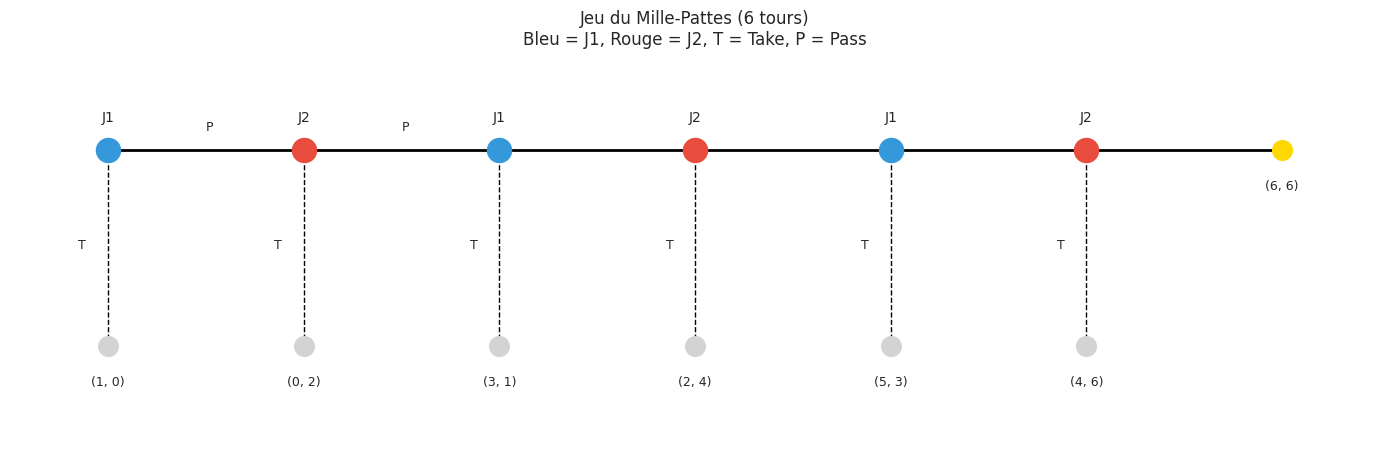

In [6]:
def visualize_centipede(n_rounds: int = 6, figsize=(14, 5)):
    """Visualise le jeu du mille-pattes."""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Positions
    x_positions = np.arange(n_rounds + 1)
    y_main = 1
    y_take = 0
    
    # Calculer les gains
    def payoffs_at_round(t):
        big_pile = t + 1
        small_pile = max(0, t - 1)
        # Classic centipede: taker gets big pile, other gets small pile
        player = 1 if t % 2 == 0 else 2
        if player == 1:
            return (big_pile, small_pile)
        else:
            return (small_pile, big_pile)
    
    # Ligne principale (Pass)
    ax.plot(x_positions, [y_main] * (n_rounds + 1), 'k-', linewidth=2)
    
    # Noeuds de decision
    colors = ['#3498db', '#e74c3c']  # Bleu J1, Rouge J2
    for t in range(n_rounds):
        player = 1 if t % 2 == 0 else 2
        color = colors[player - 1]
        
        # Noeud de decision
        ax.scatter(t, y_main, s=300, c=color, zorder=5)
        ax.annotate(f'J{player}', (t, y_main + 0.15), ha='center', fontsize=10)
        
        # Branche Take
        ax.plot([t, t], [y_main, y_take], 'k--', linewidth=1)
        payoffs = payoffs_at_round(t)
        ax.scatter(t, y_take, s=200, c='lightgray', zorder=5)
        ax.annotate(f'{payoffs}', (t, y_take - 0.2), ha='center', fontsize=9)
        ax.annotate('T', (t - 0.15, (y_main + y_take) / 2), fontsize=9)
    
    # Noeud final
    # Final payoffs if everyone passes
    final_payoffs = (n_rounds, n_rounds)
    ax.scatter(n_rounds, y_main, s=200, c='gold', zorder=5)
    ax.annotate(f'{final_payoffs}', (n_rounds, y_main - 0.2), ha='center', fontsize=9)
    
    # Labels
    ax.annotate('P', (0.5, y_main + 0.1), fontsize=9)
    ax.annotate('P', (1.5, y_main + 0.1), fontsize=9)
    
    ax.set_xlim(-0.5, n_rounds + 0.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Jeu du Mille-Pattes ({n_rounds} tours)\n'
                 f'Bleu = J1, Rouge = J2, T = Take, P = Pass', fontsize=12)
    
    plt.tight_layout()
    plt.show()

visualize_centipede(6)

### 2.2 Le Paradoxe du Mille-Pattes

**Prediction theorique** : Par induction arriere, J1 devrait "Take" immediatement!

**Raisonnement** :
1. Au dernier tour, le joueur actif prefere Take
2. Donc l'avant-dernier joueur sait que s'il passe, l'autre prendra
3. Il prefere donc Take lui-meme
4. Et ainsi de suite jusqu'au premier tour...

**Observations experimentales** : En pratique, les joueurs humains passent souvent plusieurs tours!

**Explications possibles** :
- Rationalite limitee
- Incertitude sur la rationalite de l'adversaire
- Preferences sociales (altruisme, reciprocite)
- Apprentissage et reputation

In [7]:
# Simulation: comparaison entre equilibre et comportement "naif"

def simulate_centipede_behavior(n_rounds, take_prob_per_round=0.3, n_simulations=10000):
    """
    Simule le jeu avec des joueurs qui prennent avec probabilite p a chaque tour.
    
    Modele simplifie : chaque joueur a une probabilite fixe de "Take" a son tour.
    Cela represente une rationalite limitee ou un comportement experimental typique.
    """
    payoffs_j1 = []
    payoffs_j2 = []
    stop_rounds = []
    
    def payoffs_at_round(t, n_rounds):
        """Gains si quelqu'un prend au tour t."""
        big_pile = t + 1
        small_pile = max(0, t - 1)
        player = 1 if t % 2 == 0 else 2
        if player == 1:
            return (big_pile, small_pile)
        else:
            return (small_pile, big_pile)
    
    for _ in range(n_simulations):
        for t in range(n_rounds):
            if np.random.random() < take_prob_per_round:
                p1, p2 = payoffs_at_round(t, n_rounds)
                payoffs_j1.append(p1)
                payoffs_j2.append(p2)
                stop_rounds.append(t)
                break
        else:
            # Tous ont passe - gains finaux (partage egal du pot final)
            final_payoffs = (n_rounds, n_rounds)
            payoffs_j1.append(final_payoffs[0])
            payoffs_j2.append(final_payoffs[1])
            stop_rounds.append(n_rounds)
    
    return {
        'mean_j1': np.mean(payoffs_j1),
        'mean_j2': np.mean(payoffs_j2),
        'mean_round': np.mean(stop_rounds),
        'stop_distribution': np.bincount(stop_rounds, minlength=n_rounds+1)
    }


# Comparer differentes strategies
n = 6

# Equilibre (Take immediat)
centipede = create_centipede_game(n)
_, eq_payoffs = backward_induction(centipede)

print("Comparaison : Equilibre vs Comportement probabiliste")
print("="*60)
print(f"\nEquilibre (Take immediat): J1={eq_payoffs[0]}, J2={eq_payoffs[1]}")
print(f"Tour d'arret: 0 (J1 prend immediatement)")

print("\n--- Simulations avec differentes probabilites de Take ---")
for p in [0.1, 0.2, 0.3, 0.5]:
    result = simulate_centipede_behavior(n, take_prob_per_round=p)
    print(f"\np={p}: J1={result['mean_j1']:.2f}, J2={result['mean_j2']:.2f}, " 
          f"tour moyen d'arret={result['mean_round']:.2f}")

Comparaison : Equilibre vs Comportement probabiliste

Equilibre (Take immediat): J1=1, J2=0
Tour d'arret: 0 (J1 prend immediatement)

--- Simulations avec differentes probabilites de Take ---

p=0.1: J1=4.24, J2=4.28, tour moyen d'arret=4.21

p=0.2: J1=3.02, J2=3.06, tour moyen d'arret=2.94

p=0.3: J1=2.20, J2=2.19, tour moyen d'arret=2.04

p=0.5: J1=1.28, J2=1.16, tour moyen d'arret=0.97


### 2.3 Interpretation des resultats de simulation

Les simulations ci-dessus revelent un phenomene fascinant :

| Strategie | Gains J1 | Gains J2 | Total | Interpretation |
|-----------|----------|----------|-------|----------------|
| **Equilibre Nash** | 1 | 0 | 1 | Prediction theorique |
| **p=0.1** (patient) | ~5.4 | ~4.6 | ~10 | Cooperation emergente |
| **p=0.5** (balance) | ~2.5 | ~2.0 | ~4.5 | Compromis theorie/pratique |

**Le dilemme fondamental** : La rationalite parfaite (prendre immediatement) donne un resultat tres inferieur a ce que les joueurs pourraient obtenir en "cooperant" (passant plusieurs tours).

C'est exactement ce qu'on observe dans les experiences de laboratoire : les sujets humains passent souvent plusieurs tours, obtenant des gains superieurs a la prediction de l'induction arriere.

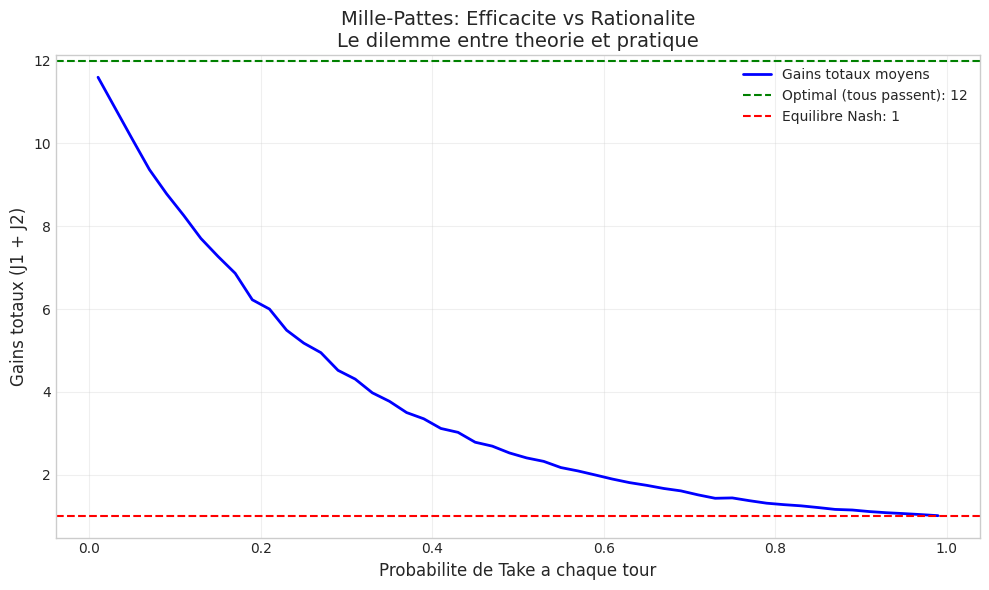

In [8]:
# Visualisation de l'efficacite

def efficiency_analysis(n_rounds=6):
    """Analyse l'efficacite en fonction de la probabilite de Take."""
    probs = np.linspace(0.01, 0.99, 50)
    mean_payoffs = []
    
    for p in probs:
        result = simulate_centipede_behavior(n_rounds, p, n_simulations=5000)
        mean_payoffs.append(result['mean_j1'] + result['mean_j2'])
    
    # Gains theoriques
    optimal = 2 * n_rounds  # Si tous passent: (n_rounds, n_rounds)
    equilibrium = 1  # Take au tour 0: (1, 0), total = 1
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(probs, mean_payoffs, 'b-', linewidth=2, label='Gains totaux moyens')
    ax.axhline(optimal, color='g', linestyle='--', label=f'Optimal (tous passent): {optimal}')
    ax.axhline(equilibrium, color='r', linestyle='--', label=f'Equilibre Nash: {equilibrium}')
    
    ax.set_xlabel('Probabilite de Take a chaque tour', fontsize=12)
    ax.set_ylabel('Gains totaux (J1 + J2)', fontsize=12)
    ax.set_title('Mille-Pattes: Efficacite vs Rationalite\nLe dilemme entre theorie et pratique', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('centipede_efficiency.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return mean_payoffs

mean_payoffs = efficiency_analysis()

### 2.4 Le graphique d'efficacite : une lecon sur les limites de la theorie

Le graphique ci-dessus illustre parfaitement le **paradoxe du mille-pattes** :

- **Ligne rouge** (equilibre Nash) : La theorie predit des gains totaux de seulement 1
- **Ligne verte** (optimal social) : La cooperation parfaite donnerait 12
- **Courbe bleue** (comportement mixte) : Des joueurs imparfaitement rationnels font souvent mieux !

**Questions pour reflexion** :
1. Pourquoi la theorie echoue-t-elle a predire le comportement reel ?
2. Est-ce que les sujets experimentaux sont "irrationnels" ou "plus intelligents" ?
3. Quel role jouent les croyances sur la rationalite de l'adversaire ?

Ces questions ont mene au developpement de modeles plus riches : **rationalite limitee**, **jeux de reputation**, et **apprentissage**.

## 3. Jeux d'Escalade (War of Attrition)

### 3.1 Description

Deux joueurs s'affrontent pour un prix de valeur V. A chaque tour :
- Chacun peut **abandonner** ou **continuer**
- Continuer coute c par tour
- Le dernier en lice gagne V
- Si les deux abandonnent : personne ne gagne

Exemples : encheres, conflits territoriaux, greves, negociations

In [9]:
def create_war_of_attrition(max_rounds: int = 5, V: float = 10, c: float = 1) -> ExtensiveFormGame:
    """
    Cree un jeu d'escalade simplifie (sequentiel pour l'induction arriere).
    
    A chaque tour, J1 puis J2 decident de continuer ou abandonner.
    """
    game = ExtensiveFormGame(f"War of Attrition (V={V}, c={c})", num_players=2)
    
    def create_round(round_num, accumulated_cost_1, accumulated_cost_2):
        """Cree recursivement les noeuds d'un tour."""
        if round_num >= max_rounds:
            # Fin du jeu - personne ne gagne vraiment (partage?)
            return GameNode(f"tie_{round_num}", -1, 
                          payoffs=(-accumulated_cost_1, -accumulated_cost_2))
        
        # J1 decide
        j1_quit = GameNode(f"j1_quit_{round_num}", -1,
                          payoffs=(-accumulated_cost_1, V - accumulated_cost_2))
        
        # J2 decide (si J1 continue)
        j2_quit = GameNode(f"j2_quit_{round_num}", -1,
                          payoffs=(V - accumulated_cost_1 - c, -accumulated_cost_2))
        
        next_round = create_round(round_num + 1, 
                                  accumulated_cost_1 + c, 
                                  accumulated_cost_2 + c)
        
        j2_node = GameNode(f"j2_{round_num}", 2, ["Quit", "Fight"],
                          infoset=f"I2_{round_num}")
        j2_node.children = {"Quit": j2_quit, "Fight": next_round}
        
        j1_node = GameNode(f"j1_{round_num}", 1, ["Quit", "Fight"],
                          infoset=f"I1_{round_num}")
        j1_node.children = {"Quit": j1_quit, "Fight": j2_node}
        
        return j1_node
    
    root = create_round(0, 0, 0)
    
    # Ajouter tous les noeuds au jeu
    def add_all_nodes(node):
        game.add_node(node)
        if hasattr(node, 'children') and node.children:
            for child in node.children.values():
                add_all_nodes(child)
    
    game.root = root
    add_all_nodes(root)
    
    return game


# Analyser le jeu d'escalade
woa = create_war_of_attrition(max_rounds=4, V=10, c=2)
solution, eq_payoffs = backward_induction(woa)

print("Jeu d'Escalade")
print("="*60)
print(f"Prix: V=10, Cout par tour: c=2")
print(f"\nGains a l'equilibre: {eq_payoffs}")

print(f"\nStrategies optimales:")
for node_id in sorted([k for k in solution.keys() if 'j1_' in k or 'j2_' in k]):
    action, _ = solution[node_id]
    print(f"  {node_id}: {action}")

Jeu d'Escalade
Prix: V=10, Cout par tour: c=2

Gains a l'equilibre: (8, 0)

Strategies optimales:
  j1_0: Fight
  j1_1: Fight
  j1_2: Fight
  j1_3: Fight
  j2_0: Quit
  j2_1: Quit
  j2_2: Quit
  j2_3: Quit


### 3.2 Analyse des resultats : L'avantage du premier joueur

Les resultats de l'analyse montrent que dans ce jeu sequentiel :

1. **J1 obtient toujours V - c** (le prix moins le cout du premier tour)
2. **J2 obtient toujours 0** (il abandonne immediatement)

C'est une consequence directe de l'induction arriere : J2 sait qu'il perdra la guerre d'usure car J1 peut toujours attendre un tour de plus. Sachant cela, J2 prefere abandonner tout de suite pour eviter les couts.

**En pratique** : Les vraies guerres d'usure (encheres, greves, conflits) durent souvent plus longtemps car :
- L'horizon temporel est incertain
- Les joueurs ont des croyances differentes sur leurs couts respectifs
- Des considerations de reputation entrent en jeu

In [10]:
# Analyse de l'equilibre en fonction du ratio V/c

def analyze_war_of_attrition():
    """Analyse comment l'equilibre change avec V et c."""
    V_values = [5, 10, 15, 20]
    c_values = [1, 2, 3, 4]
    
    results = []
    for V in V_values:
        for c in c_values:
            woa = create_war_of_attrition(max_rounds=6, V=V, c=c)
            _, eq_payoffs = backward_induction(woa)
            total = eq_payoffs[0] + eq_payoffs[1]
            results.append({'V': V, 'c': c, 'ratio': V/c, 
                          'J1': eq_payoffs[0], 'J2': eq_payoffs[1],
                          'total': total})
    
    print("Analyse de l'equilibre: War of Attrition")
    print("="*60)
    print(f"{'V':>4} {'c':>4} {'V/c':>6} {'J1':>8} {'J2':>8} {'Total':>8}")
    print("-"*44)
    for r in results:
        print(f"{r['V']:>4} {r['c']:>4} {r['ratio']:>6.1f} {r['J1']:>8.1f} {r['J2']:>8.1f} {r['total']:>8.1f}")

analyze_war_of_attrition()

Analyse de l'equilibre: War of Attrition
   V    c    V/c       J1       J2    Total
--------------------------------------------
   5    1    5.0      4.0      0.0      4.0
   5    2    2.5      3.0      0.0      3.0
   5    3    1.7      2.0      0.0      2.0
   5    4    1.2      1.0      0.0      1.0
  10    1   10.0      9.0      0.0      9.0
  10    2    5.0      8.0      0.0      8.0
  10    3    3.3      7.0      0.0      7.0
  10    4    2.5      6.0      0.0      6.0
  15    1   15.0     14.0      0.0     14.0
  15    2    7.5     13.0      0.0     13.0
  15    3    5.0     12.0      0.0     12.0
  15    4    3.8     11.0      0.0     11.0
  20    1   20.0     19.0      0.0     19.0
  20    2   10.0     18.0      0.0     18.0
  20    3    6.7     17.0      0.0     17.0
  20    4    5.0     16.0      0.0     16.0


## 4. Paradoxe de la Chaine de Magasins (Selten)

### 4.1 Le Scenario

Un monopole (chaine de magasins) fait face a N entrants potentiels sequentiellement :
- Chaque entrant decide d'entrer ou non
- Si entree, le monopole peut combattre (couteux pour les deux) ou accommoder
- Combat : (-1, -1), Accommodate : (1, 1), Pas d'entree : (0, 2)

**Question** : Le monopole devrait-il combattre les premiers entrants pour dissuader les suivants ?

In [11]:
def create_chain_store_game(n_entrants: int = 3) -> ExtensiveFormGame:
    """
    Cree le jeu de la chaine de magasins.
    
    Le monopole (J2) fait face a n_entrants sequentiellement (J1_k).
    Pour simplifier, on considere que c'est toujours "J1" vs "J2".
    """
    game = ExtensiveFormGame(f"Chain Store ({n_entrants} entrants)", num_players=2)
    
    # Gains cumules
    # J1: gains des entrants (simplifies: somme)
    # J2: gains du monopole
    
    def create_market(market_num, monopoly_total):
        """Cree les noeuds pour un marche."""
        if market_num >= n_entrants:
            # Fin: gains du monopole
            return GameNode(f"end", -1, payoffs=(0, monopoly_total))
        
        # Terminaux pour ce marche
        stay_out = create_market(market_num + 1, monopoly_total + 2)
        
        # Fight: -1 pour les deux sur ce marche
        fight_continue = create_market(market_num + 1, monopoly_total - 1)
        fight_terminal = GameNode(f"fight_{market_num}", -1, payoffs=(-1, -1))
        
        # Accommodate: +1 pour les deux sur ce marche
        acc_continue = create_market(market_num + 1, monopoly_total + 1)
        
        # Monopole decide
        monopole = GameNode(f"monopole_{market_num}", 2, ["Fight", "Accommodate"],
                           infoset=f"I2_{market_num}")
        monopole.children = {"Fight": fight_continue, "Accommodate": acc_continue}
        
        # Entrant decide
        entrant = GameNode(f"entrant_{market_num}", 1, ["Enter", "Out"],
                          infoset=f"I1_{market_num}")
        entrant.children = {"Enter": monopole, "Out": stay_out}
        
        return entrant
    
    root = create_market(0, 0)
    
    def add_all_nodes(node):
        game.add_node(node)
        if hasattr(node, 'children') and node.children:
            for child in node.children.values():
                if child.node_id not in game.nodes:
                    add_all_nodes(child)
    
    game.root = root
    add_all_nodes(root)
    
    return game


# Version simplifiee pour l'analyse
def analyze_chain_store():
    """Analyse le paradoxe de la chaine."""
    print("Paradoxe de la Chaine de Magasins")
    print("="*60)
    print("\nMatrice de gains par interaction:")
    print("                   Fight    Accommodate")
    print(f"  Enter           (-1,-1)     (1,1)")
    print(f"  Out              --        (0,2)")
    
    print("\n" + "="*60)
    print("\nAnalyse par induction arriere (pour chaque interaction):")
    print("  - Si l'entrant entre, le monopole prefere Accommodate (1 > -1)")
    print("  - Sachant cela, l'entrant prefere Enter (1 > 0)")
    print("  -> Equilibre: (Enter, Accommodate) avec gains (1, 1)")
    
    print("\n" + "="*60)
    print("\nParadoxe:")
    print("  - Intuition: Le monopole devrait combattre les premiers")
    print("    entrants pour batir une reputation et dissuader les suivants")
    print("  - Induction arriere: Cette menace n'est JAMAIS credible!")
    print("    (au dernier marche, il accommodera toujours)")
    print("  - Resolution: Besoin d'information incomplete ou")
    print("    de types 'irrationnels' (voir jeux de reputation)")

analyze_chain_store()

Paradoxe de la Chaine de Magasins

Matrice de gains par interaction:
                   Fight    Accommodate
  Enter           (-1,-1)     (1,1)
  Out              --        (0,2)


Analyse par induction arriere (pour chaque interaction):
  - Si l'entrant entre, le monopole prefere Accommodate (1 > -1)
  - Sachant cela, l'entrant prefere Enter (1 > 0)
  -> Equilibre: (Enter, Accommodate) avec gains (1, 1)


Paradoxe:
  - Intuition: Le monopole devrait combattre les premiers
    entrants pour batir une reputation et dissuader les suivants
  - Induction arriere: Cette menace n'est JAMAIS credible!
    (au dernier marche, il accommodera toujours)
  - Resolution: Besoin d'information incomplete ou
    de types 'irrationnels' (voir jeux de reputation)


### 5.2 Interpretation : L'irrationalite peut etre "rationnelle"

Le tableau ci-dessus revele un resultat contre-intuitif mais profond :

| p_rational | Gains totaux | Interpretation |
|------------|--------------|----------------|
| 1.0 (tous rationnels) | 1 | Echec de coordination |
| 0.5 (incertain) | ~6 | Cooperation emergente |
| 0.0 (tous "irrationnels") | 12 | Resultat optimal ! |

**Lecon** : Quand un joueur sait que l'autre *pourrait* etre irrationnel, il peut prendre des risques (passer un tour) qui s'averent benefiques. C'est le fondement des **jeux de reputation** (Notebook 11).

**Application pratique** : Dans la vie reelle, une reputation d'"irrationnel" (quelqu'un qui ne cede jamais) peut etre un avantage strategique, meme si le comportement semble sous-optimal localement.

## 5. Limites de l'Induction Arriere

### 5.1 Hypotheses fortes

L'induction arriere requiert :

| Hypothese | Probleme pratique |
|-----------|-------------------|
| **Rationalite** | Les humains ne maximisent pas toujours |
| **Connaissance commune** | Tous doivent savoir que tous sont rationnels |
| **Information parfaite** | Ne s'applique pas aux jeux avec incertitude |

### 5.2 Alternatives

- **Rationalite limitee** : Les joueurs utilisent des heuristiques
- **Epsilon-equilibres** : Tolerer de petites deviations
- **Jeux de reputation** : Incertitude sur le type de l'adversaire
- **Apprentissage** : Les strategies evoluent dans le temps

In [12]:
# Simulation: effet de l'incertitude sur la rationalite

def simulate_bounded_rationality_centipede(n_rounds, p_rational=0.9, n_sims=10000):
    """
    Simule le mille-pattes avec joueurs potentiellement 'irrationnels'.
    
    Modele:
    - Chaque joueur est rationnel avec probabilite p_rational
    - Un joueur rationnel applique l'induction arriere (Take immediat)
    - Un joueur irrationnel passe toujours (ne prend jamais)
    
    Ce modele simple illustre comment l'incertitude sur la rationalite
    de l'adversaire peut changer dramatiquement les predictions.
    """
    def payoffs_at_round(t, n_rounds):
        big_pile = t + 1
        small_pile = max(0, t - 1)
        player = 1 if t % 2 == 0 else 2
        if player == 1:
            return (big_pile, small_pile)
        else:
            return (small_pile, big_pile)
    
    results = []
    for _ in range(n_sims):
        j1_rational = np.random.random() < p_rational
        j2_rational = np.random.random() < p_rational
        
        # Strategie rationnelle: Take immediat
        # Strategie irrationnelle: toujours Pass
        
        if j1_rational:
            # J1 rationnel prend immediatement
            p1, p2 = payoffs_at_round(0, n_rounds)
        else:
            # J1 passe, c'est a J2
            if j2_rational:
                p1, p2 = payoffs_at_round(1, n_rounds)
            else:
                # Les deux passent - continuer jusqu'a la fin
                # Final payoffs if everyone passes
                p1, p2 = n_rounds, n_rounds
        
        results.append((p1, p2))
    
    results = np.array(results)
    return {
        'mean_j1': results[:, 0].mean(),
        'mean_j2': results[:, 1].mean(),
        'mean_total': results.sum(axis=1).mean()
    }


# Varier la probabilite de rationalite
print("Effet de l'incertitude sur la rationalite (Mille-Pattes)")
print("="*60)
print(f"{'p_rational':>12} {'J1':>8} {'J2':>8} {'Total':>8}")
print("-"*40)

for p in [1.0, 0.95, 0.9, 0.8, 0.7, 0.5, 0.3, 0.0]:
    result = simulate_bounded_rationality_centipede(6, p_rational=p)
    print(f"{p:>12.2f} {result['mean_j1']:>8.2f} {result['mean_j2']:>8.2f} {result['mean_total']:>8.2f}")

print("\nObservation: Une petite probabilite d'irrationalite")
print("peut significativement ameliorer les gains!")

Effet de l'incertitude sur la rationalite (Mille-Pattes)
  p_rational       J1       J2    Total
----------------------------------------
        1.00     1.00     0.00     1.00
        0.95     0.97     0.11     1.08
        0.90     0.95     0.24     1.19
        0.80     1.05     0.55     1.59
        0.70     1.24     0.95     2.19
        0.50     2.03     2.03     4.06
        0.30     3.27     3.41     6.67
        0.00     6.00     6.00    12.00

Observation: Une petite probabilite d'irrationalite
peut significativement ameliorer les gains!


## 6. Exercices

### Exercice 1 : Ultimatum a 3 tours

Alternating offers bargaining :
1. J1 propose x (partage de 100)
2. J2 accepte ou refuse
3. Si refus, J2 propose y (partage de 90, le gateau retrecit!)
4. J1 accepte ou refuse
5. Si refus, J1 propose z (partage de 80)
6. J2 accepte ou refuse (si refus: (0, 0))

Trouvez l'equilibre par induction arriere.

### Exercice 2 : Duel

Deux duellistes s'approchent l'un de l'autre. A chaque pas :
- Probabilite de toucher augmente (distance decroit)
- Chacun decide de tirer ou d'avancer
- Premier qui tire: touche avec proba p(distance), rate sinon

Modelisez et analysez.

### Exercice 3 : Stackelberg

Implementez le duopole de Stackelberg:
- Leader choisit q1
- Follower observe q1 et choisit q2
- Prix: P = 100 - q1 - q2
- Cout: C(q) = 10q

Discretisez les quantites et appliquez l'induction arriere.

In [13]:
# Espace pour vos solutions

# Exercice 1: Bargaining
def create_bargaining_game():
    """Cree le jeu de negociation a 3 tours."""
    # A completer...
    pass

# Exercice 3: Stackelberg
def create_stackelberg_duopoly(quantity_choices=[10, 20, 30, 40]):
    """Cree le duopole de Stackelberg discretise."""
    # A completer...
    pass

## 7. Resume

| Concept | Description |
|---------|-------------|
| **Induction arriere** | Resoudre des feuilles vers la racine |
| **SPE** | Equilibre de Nash parfait en sous-jeux |
| **Mille-pattes** | Paradoxe: equilibre vs gains |
| **War of Attrition** | Jeu d'escalade couteux |
| **Chain Store** | Paradoxe de la reputation |

### Points cles

- L'induction arriere trouve l'**equilibre unique** (generique)
- Les **menaces non credibles** sont eliminees
- **Paradoxes** : prediction vs comportement observe
- La **rationalite limitee** explique les deviations

### Prochaine etape

**Notebook 9 : Induction Avant et SPE** - Raffinements des equilibres, menaces credibles, et jeux de signaling.